# Model training

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import time

import data_reader
import dataset
from plots import learning_curve_train

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
# Training and data variables

MODE = "w"
EXP_NAME = "25ep"

DATA_SET_NAME = f"data_set_x20_100%_split"
PATCH_SIZE = 512

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

#threshold = 0.05 # Loss difference for early stopping

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    net = torchvision.models.resnet18(pretrained=True).to(device)

    #print(f"Loading {MODEL_NAME}")
    #net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading
    
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers 

    net.fc = nn.Sequential(
                  nn.Dropout(p=0.5),  
                  nn.Linear(512, 2)
                #nn.Linear(512, 3),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 3),
                #nn.Softmax(dim = -1)
                ).to(device)

    for param in net.fc.parameters():
        param.requires_grad = True

    #for param in net.layer3.parameters():
    #    param.requires_grad = True
    
    for param in net.layer4[1].parameters():
        param.requires_grad = True # Unfreezing the last residual block

    net.fc.apply(init_weights) # Xavier init

    n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    print("Number of free parameters: ", n_params)

    #Hyperparameters:
    learning_rate = 1E-4 # LR
    loss_function = nn.CrossEntropyLoss()  # Loss
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    
    y_pred = [torch.argmax(i) for i in outputs.cpu()]
    y_true = [torch.argmax(i) for i in y.cpu()]

    #acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    conf_m = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return [acc, loss, conf_m, f1, auc]

In [8]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)
  patience = 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1, auc = 0, 0, 0, 0
      val_acc, val_loss, val_f1, val_auc = 0, 0, 0, 0
      conf_m, val_conf_m = np.zeros((2,2)), np.zeros((2,2))

      print("\nEPOCH: ", epoch+1)

      n_patches = sum(len(batch[0]) for batch in iter(train_dataloader))

      for batch_X, batch_y in tqdm(iter(train_dataloader)):
         # Number of patches in dataloader
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0,3,2,1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        performance_metrics = fwd_pass(batch_X, batch_y, train=True)
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]
        acc += acc_aux*(len(batch_X)/n_patches) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/n_patches)
        conf_m += conf_m_aux
        f1 += f1_aux*(len(batch_X)/n_patches)
        auc += auc_aux*(len(batch_X)/n_patches)

      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          performance_metrics = fwd_pass(batch_X, batch_y, train=False)
          
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]  
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_auc += auc_aux*(len(batch_X)/len(val_set))
        
      print("Val loss: ", val_loss.item(), " Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc, " Train acc: ", acc, "\n")
      print("Val AUC: ", val_auc, " Train AUC: ", auc)
      print("Val f1: ", val_f1, " Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m, "\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(auc),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_auc),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if val_loss.item()>loss.item():#> threshold:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 7:
        print("Stopping early: ")
        break

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

In [9]:
# Choosing only the images from the according splits (10CV)

SPLITS = [9] # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in SPLITS:
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits-1: # For the final split for validation we take the firs one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)
        train_set.case_ids.extend(patch_ids_)

    # Random oversampler
    negative =  [i[0] for i in train_set.labels]
    positive =  [i[1] for i in train_set.labels]

    class_sample_count = np.array([sum(negative) , sum(positive)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[np.argmax(t)] for t in train_set.labels])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 2*int(sum(positive)))#, replacement=False) #int(len(train_set)))#
    # Will take len(samples_weight) number of samples, this can be changed

    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)
    val_set.case_ids.extend(patch_ids_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    init()

    train()

    del train_set, val_set, test_set


Loading training split: 1
Read lmdb
8207
Loading training split: 2
Read lmdb
9777
Loading training split: 3
Read lmdb
9243
Loading training split: 4
Read lmdb
8730
Loading training split: 5
Read lmdb
8520
Loading training split: 6
Read lmdb
8464
Loading training split: 7
Read lmdb
8236
Loading training split: 8
Read lmdb
7714
Patches for training: 68891

Loading validation split: 9
Read lmdb
9329
Patches for validation: 9329

Number of free parameters:  1026
25ep9

EPOCH:  1


c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Val loss:  0.031181003898382187  Train loss:  0.06102379038929939 

Val acc:  0.9881016186086493  Train acc:  0.9806926999129714 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9876634451916203  Train f1:  0.9788359437316186 

Val CONF: 
 [[4437.    5.]
 [ 106. 4781.]] 
Train CONF: 
 [[15777.   349.]
 [  272. 15766.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Val loss:  0.01862655021250248  Train loss:  0.029763884842395782 

Val acc:  0.9939972129917554  Train acc:  0.9904240766074169 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9939750570296462  Train f1:  0.9895204729563445 

Val CONF: 
 [[4424.   18.]
 [  38. 4849.]] 
Train CONF: 
 [[15790.   179.]
 [  129. 16066.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.017328888177871704  Train loss:  0.02186034433543682 

Val acc:  0.9939972129917556  Train acc:  0.9920718816067958 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9930907470686015  Train f1:  0.9906501147964017 

Val CONF: 
 [[4426.   16.]
 [  40. 4847.]] 
Train CONF: 
 [[15858.   152.]
 [  103. 16051.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.012386330403387547  Train loss:  0.016397349536418915 

Val acc:  0.994747561367787  Train acc:  0.9943414998134883 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9947280810847129  Train f1:  0.9936749196359349 

Val CONF: 
 [[4431.   11.]
 [  38. 4849.]] 
Train CONF: 
 [[15845.   105.]
 [   77. 16137.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.012717639096081257  Train loss:  0.012735695578157902 

Val acc:  0.995283524493524  Train acc:  0.9955229449073827 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9953245102175451  Train f1:  0.9948629453439736 

Val CONF: 
 [[4430.   12.]
 [  32. 4855.]] 
Train CONF: 
 [[16077.    88.]
 [   56. 15943.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.013990496285259724  Train loss:  0.008509605191648006 

Val acc:  0.9948547539929343  Train acc:  0.9972018405671284 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9945000690871497  Train f1:  0.9968526740765348 

Val CONF: 
 [[4431.   11.]
 [  37. 4850.]] 
Train CONF: 
 [[16004.    58.]
 [   32. 16070.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Val loss:  0.01248825155198574  Train loss:  0.007983551360666752 

Val acc:  0.9954979097438187  Train acc:  0.9970152966049344 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9952804046180129  Train f1:  0.9967337764142777 

Val CONF: 
 [[4430.   12.]
 [  30. 4857.]] 
Train CONF: 
 [[16107.    58.]
 [   38. 15961.]] 

Learning Rate:  2.621440000000001e-05

EPOCH:  8


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.011099344119429588  Train loss:  0.007205036003142595 

Val acc:  0.996462643370145  Train acc:  0.9976060191518815 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9964328117313015  Train f1:  0.9975246664440289 

Val CONF: 
 [[4436.    6.]
 [  27. 4860.]] 
Train CONF: 
 [[16050.    45.]
 [   32. 16037.]] 

Learning Rate:  2.097152000000001e-05

EPOCH:  9


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Val loss:  0.01271089632064104  Train loss:  0.0063103302381932735 

Val acc:  0.9960338728695554  Train acc:  0.9979791070762696 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9958158947784578  Train f1:  0.9976727425030734 

Val CONF: 
 [[4433.    9.]
 [  28. 4859.]] 
Train CONF: 
 [[16047.    37.]
 [   28. 16052.]] 

Learning Rate:  1.677721600000001e-05

EPOCH:  10


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.017029331997036934  Train loss:  0.006319698877632618 

Val acc:  0.9949619466180817  Train acc:  0.9984765576421201 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9951145507518957  Train f1:  0.9981353657954554 

Val CONF: 
 [[4.440e+03 2.000e+00]
 [4.500e+01 4.842e+03]] 
Train CONF: 
 [[15982.    25.]
 [   24. 16133.]] 

Learning Rate:  1.3421772800000007e-05

EPOCH:  11


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Val loss:  0.010850973427295685  Train loss:  0.005889531224966049 

Val acc:  0.9962482581198504  Train acc:  0.9983211043402916 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9962160431492585  Train f1:  0.9975652999280451 

Val CONF: 
 [[4433.    9.]
 [  26. 4861.]] 
Train CONF: 
 [[15967.    32.]
 [   22. 16143.]] 

Learning Rate:  1.0737418240000007e-05

EPOCH:  12


  0%|          | 0/2011 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Val loss:  0.013055057264864445  Train loss:  0.004261967726051807 

Val acc:  0.9962482581198505  Train acc:  0.9986631016043138 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.9957958067955847  Train f1:  0.9983440905309704 

Val CONF: 
 [[4431.   11.]
 [  24. 4863.]] 
Train CONF: 
 [[16225.    25.]
 [   18. 15896.]] 

Learning Rate:  8.589934592000006e-06
Stopping early: 


c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


25ep0


c:\Users\Alejandro\Desktop\heterogeneous-data\src\WSI\plots.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


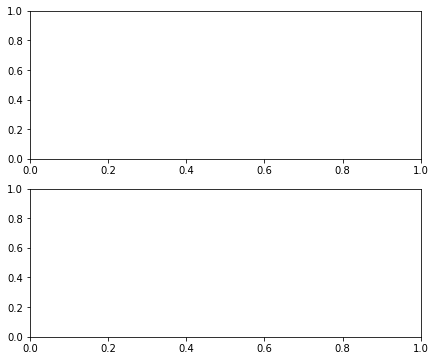

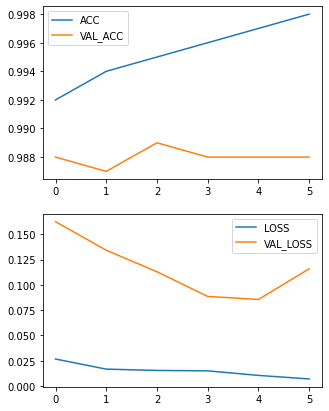

In [10]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve_train(NAME)